In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pickle
import json
import warnings
import datetime
warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
% matplotlib inline

In [59]:
from model_generator import *

### Load models, parameters and df

In [60]:
model = pickle.load(open('models_p/pipeline_stack.p', 'rb'))
features_list_stack = json.load(open('inputs_json/feature_list_band_stack.json', 'r'))
arima_parameters = json.load(open('inputs_json/arima_band_parameters_stack_model.json', 'r'))
ar_param = [arima_parameters['ar']]
std_innovations = arima_parameters['std']
paths_dict_band = json.load(open('inputs_json/paths_dict_band.json', 'r'))

In [66]:
lgbm = pickle.load(open('models_p/lgbm_band_group.p', 'rb'))
rf = pickle.load(open('models_p/rf_model_grouped.p', 'rb'))
knn = pickle.load(open('models_p/knn_band_group.p', 'rb'))
features_list = json.load(open('inputs_json/feature_list_band_wo_hour_day_season.json', 'r'))

In [67]:
band_2017 = generate_df(paths_dict_band, 'band', '2017')
df = band_2017.return_completed_df()
name_list_24 = ['band']
feature_eng_df_2017 = band_2017.return_df_feature_engineering(name_list_24)
feature_eng_df_2017 = feature_eng_df_2017[feature_eng_df_2017.index >= '2017']
feature_eng_df_2017['winter'] = 1

In [68]:
band_mean_vol_aemet_2017 = pd.read_csv('aemet/band_mean_vol_pred_aemet_2017.csv', 
                            encoding='latin1', index_col=0)

In [69]:
final_df = feature_eng_df_2017.merge(band_mean_vol_aemet_2017, how='left', left_index=True, right_index=True)

In [70]:
for feature in ['pred_band_mean_aemet', 'pred_band_vol_aemet']:
    final_df[feature].fillna(method='pad', inplace=True)

In [71]:
final_df = final_df[final_df.index < '2017-03-19']

### Check predictions for 2017

In [72]:
lgbm_2017 = forecast_2017_samples(df=final_df, feature_list=features_list, 
                                  output='band', fitted_model=lgbm,
                                  ar_param=None, ar_order=None, 
                                  ma_param=None, ma_order=None,
                                  std=None)

rf_2017 = forecast_2017_samples(df=final_df, feature_list=features_list, 
                                  output='band', fitted_model=rf,
                                  ar_param=None, ar_order=None, 
                                  ma_param=None, ma_order=None,
                                  std=None)

knn_2017 = forecast_2017_samples(df=final_df, feature_list=features_list, 
                                  output='band', fitted_model=knn,
                                  ar_param=None, ar_order=None, 
                                  ma_param=None, ma_order=None,
                                  std=None)

In [73]:
lgbm_pred = lgbm_2017.get_2017_predictions_from_base_model().rename(columns={'y_pred':'lgbm'})

MAE: 5.9143, MSE: 53.8590


In [74]:
rf_pred = rf_2017.get_2017_predictions_from_base_model().rename(columns={'y_pred':'rf'})

MAE: 5.9574, MSE: 55.6190


In [75]:
knn_pred = knn_2017.get_2017_predictions_from_base_model().rename(columns={'y_pred':'knn'})

MAE: 6.9762, MSE: 78.9498


In [76]:
inputs_for_stack = lgbm_pred[['lgbm', 'y_true']].merge(knn_pred[['knn']], 
                                                       how='left', 
                                                       left_index=True, 
                                                       right_index=True).merge(rf_pred[['rf']], 
                                                       how='left', 
                                                       left_index=True, 
                                                       right_index=True)

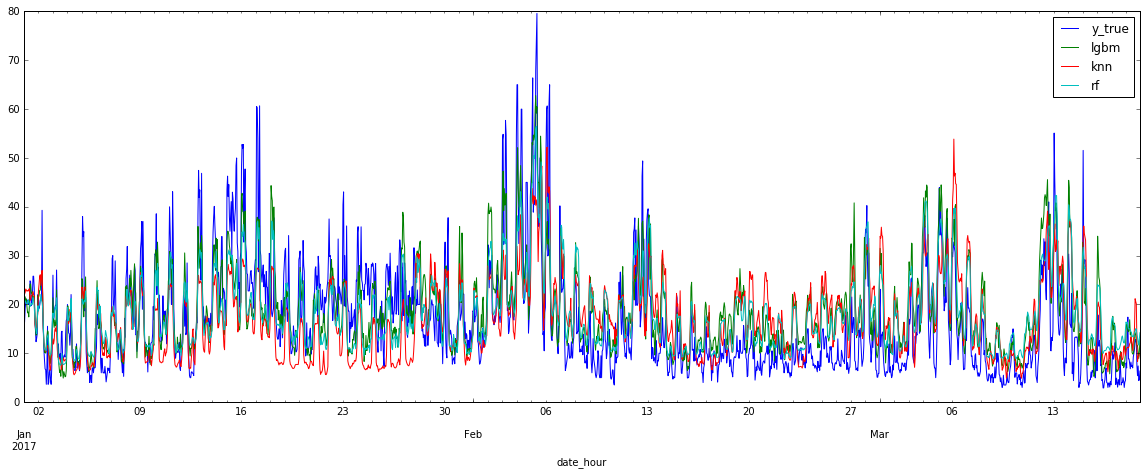

In [77]:
inputs_for_stack[['y_true', 'lgbm', 'knn', 'rf']].plot(figsize=(20,7));

### Stacked model

In [78]:
inputs_for_stack['hour'] = inputs_for_stack.index.hour.astype(str)

In [79]:
for feature in ['hour']:
    inputs_for_stack[pd.get_dummies(inputs_for_stack[feature], drop_first=True).columns.tolist()] = pd.get_dummies(inputs_for_stack[feature], drop_first=True)

In [80]:
weekday_dict = {
            0:'L', 1:'M', 2:'X', 3:'J', 4:'V', 5:'S', 6:'D' 
}
inputs_for_stack['date'] = pd.to_datetime(inputs_for_stack.index.date)
inputs_for_stack['weekday'] = pd.to_datetime(inputs_for_stack['date']).dt.dayofweek
inputs_for_stack.replace({'weekday':weekday_dict}, inplace=True)

In [83]:
inputs_for_stack[pd.get_dummies(inputs_for_stack['weekday'], drop_first=True).columns.tolist()] = pd.get_dummies(inputs_for_stack['weekday'], drop_first=True)

In [85]:
stacked_2017 = forecast_2017_samples(df=inputs_for_stack, feature_list=features_list_stack, output='y_true', fitted_model=model,
                                    ar_param=ar_param, ar_order=[24], 
                                    ma_param=[], ma_order=[],
                                    std=std_innovations)

In [86]:
stacked_pred = stacked_2017.get_2017_predictions_from_base_model()

MAE: 6.1587, MSE: 57.0382


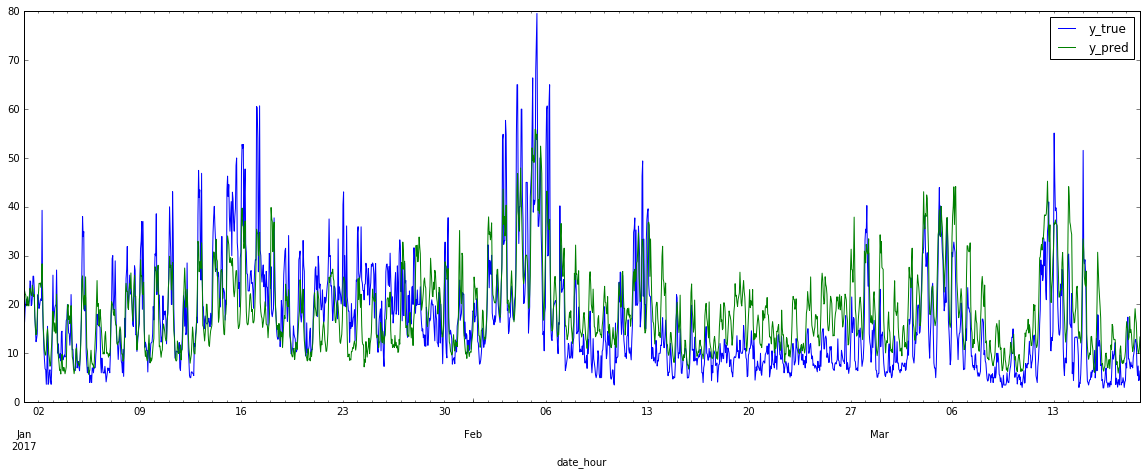

In [87]:
stacked_pred[['y_true', 'y_pred']].plot(figsize=(20,7));

### AR effect
$$S_{t} = f(X_{t})e^{Z_{t}} \\$$

$$Z_{t} = \alpha_{24} \cdot Z_{t-24}  + \epsilon _{t}$$

$$S_{t} = f(x)e^{(\alpha_{24} \cdot Z_{t-24}  +\epsilon _{t})}$$

##### Example without white noise

In [88]:
model_stacked_arima = stacked_2017.get_2017_predictions_arima_effect()

MAE: 5.9869, MSE: 54.5267


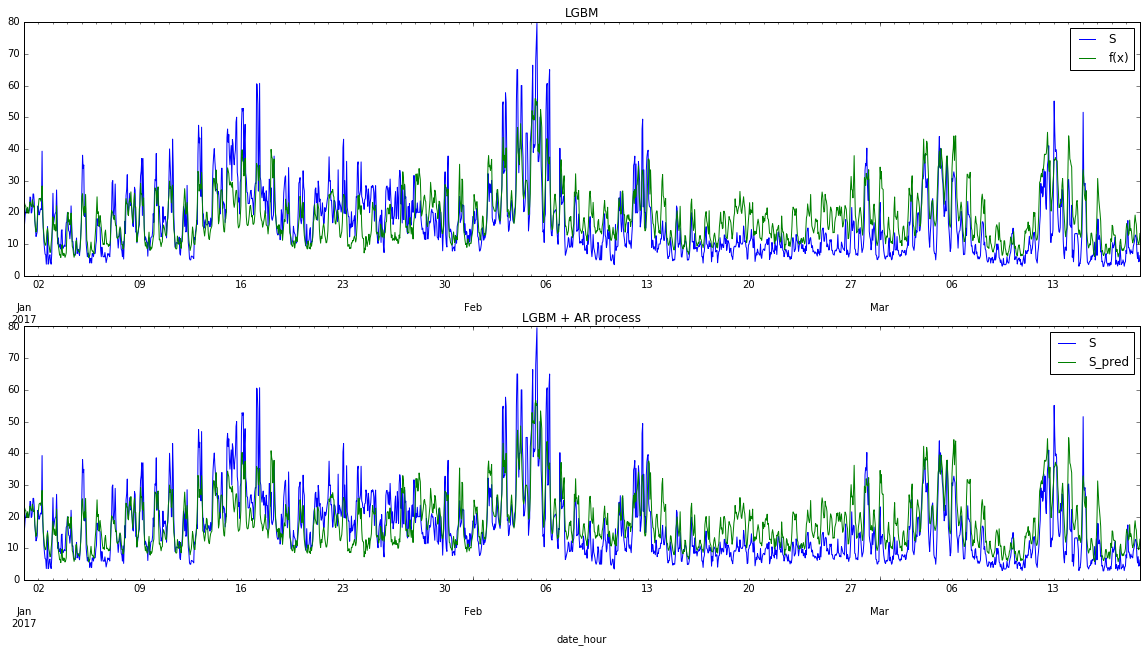

In [89]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(20,10))
model_stacked_arima[['S', 'f(x)']].plot(ax=ax0)
ax0.set_title('LGBM')
model_stacked_arima[['S','S_pred']].plot(ax=ax1)
ax1.set_title('LGBM + AR process');

##### Example with white noise 

In [90]:
np.random.seed(0)
model_stacked_arima_noise = stacked_2017.get_2017_predictions_with_noise()

MAE: 7.4673, MSE: 98.9290


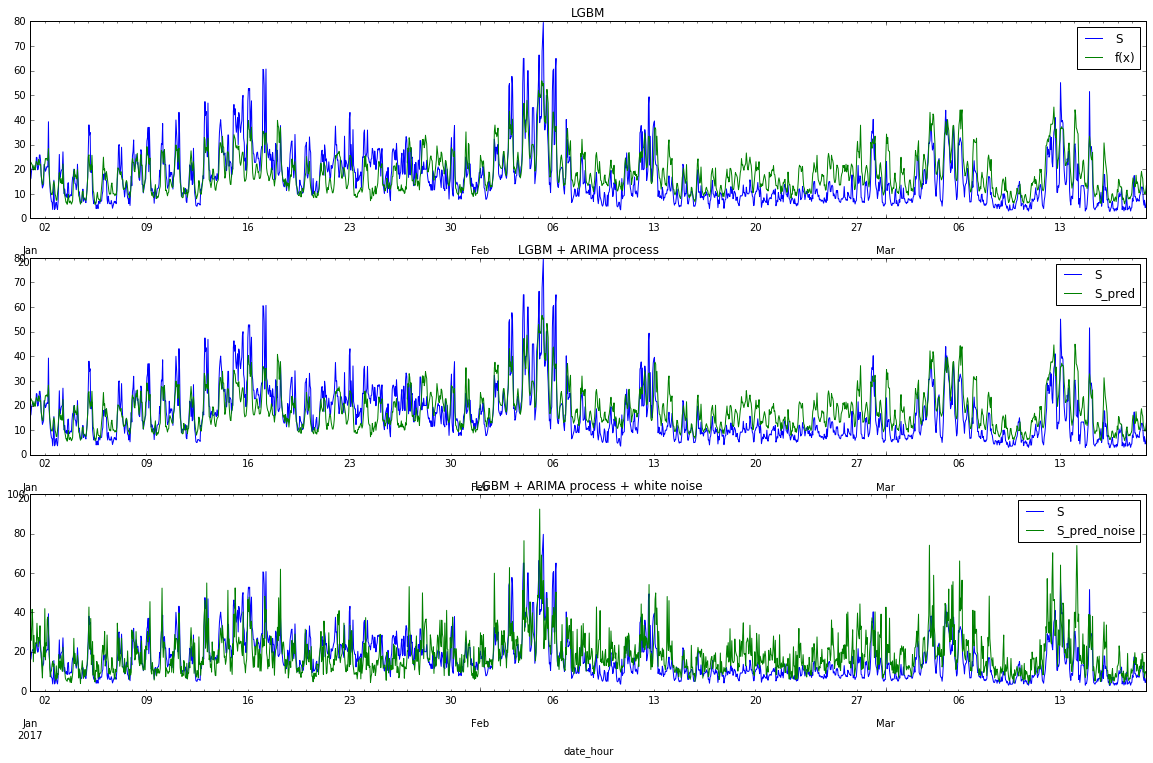

In [91]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1, figsize=(20,12))
model_stacked_arima_noise[['S', 'f(x)']].plot(ax=ax0)
ax0.set_title('LGBM')
model_stacked_arima_noise[['S', 'S_pred']].plot(ax=ax1)
ax1.set_title('LGBM + ARIMA process')
model_stacked_arima_noise[['S', 'S_pred_noise']].plot(ax=ax2)
ax2.set_title('LGBM + ARIMA process + white noise');

### Export Stacked + AR model

In [92]:
model_stacked_arima.to_json('inputs_json/stacked_arima_base.json', orient='index', date_format='iso')